In [86]:
import yfinance as yf
import numpy as np

symbol = '^GSPC'
data = yf.download(symbol, start='2020-01-01', end='2023-01-01')

prices = data['Close'].to_numpy().flatten()


/tmp/ipython-input-3237618815.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start='2020-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed


In [87]:
def getTrendState(priceSeries, currentIndex, windowSize):
    # 1. Collect past `windowSize + 1` prices
    if currentIndex - windowSize >= 0:
        priceWindow = priceSeries[currentIndex - windowSize : currentIndex + 1]
    else:
        # pad missing past prices with zeros
        missingCount = windowSize - currentIndex
        priceWindow = np.concatenate(
            (np.zeros(missingCount), priceSeries[0 : currentIndex + 1])
        )

    # 2. Convert to price differences (momentum)
    priceDiffs = np.diff(priceWindow)
    return priceDiffs


In [88]:
class TradingPortfolio:
    def __init__(self, initialCash=10000):
        # Amount of money available to buy stocks
        self.cash = initialCash

        # Number of stocks currently owned
        self.numStocks = 0

        # Total portfolio value = cash + stocks * current price
        self.totalValue = initialCash

        # Price at which the last stock was bought (for profit calculation)
        self.lastBuyPrice = 0

    def step(self, action, currentPrice):
        """
        Execute an action (Hold, Buy, Sell) and return reward.

        Parameters:
        action: int (0=Hold, 1=Buy, 2=Sell)
        currentPrice: float, stock price at current time step

        Returns:
        reward: float, profit/loss from the action
        """
        reward = 0

        if action == 1:  # Buy
            if self.cash >= currentPrice:
                self.numStocks += 1
                self.cash -= currentPrice
                self.lastBuyPrice = currentPrice
                # Buying has no immediate reward
        elif action == 2:  # Sell
            if self.numStocks > 0:
                self.numStocks -= 1
                self.cash += currentPrice
                # Reward is the profit/loss from this sell
                reward = currentPrice - self.lastBuyPrice
        # Hold (action=0) → do nothing, reward = 0

        # Update total portfolio value
        self.totalValue = self.cash + self.numStocks * currentPrice

        return reward


In [89]:
def discretizeState(state, threshold=2):
    # state: 1D numpy array
    discreteState = []
    for diff in state.flatten():  # flatten just in case
        if diff < -threshold:
            discreteState.append(-1)
        elif diff > threshold:
            discreteState.append(1)
        else:
            discreteState.append(0)
    return tuple(discreteState)  # return tuple so it can be a dictionary key


In [90]:
qTable = {}  # key = discrete state tuple, value = [Q_Hold, Q_Buy, Q_Sell]
actions = [0, 1, 2]  # Hold, Buy, Sell

alpha = 0.1       # learning rate
gamma = 0.9       # discount factor
numEpisodes = 10
windowSize = 5
threshold=0.5

epsilon = 0.3  # 50% exploration

for episode in range(numEpisodes):
    tradingPortfolio = TradingPortfolio(initialCash=1000000)

    for t in range(windowSize, len(prices)):
        # 1. Get continuous state and discretize it
        state = getTrendState(prices, t, windowSize)
        discreteState = discretizeState(state, threshold)

        # 2. Choose action
        if np.random.rand() < epsilon or discreteState not in qTable:
            action = np.random.choice(actions)
        else:
            action = np.argmax(qTable[discreteState])  # exploit

        # 3. Take action and get reward
        reward = tradingPortfolio.step(action, prices[t])

        # 4. Get next state
        if t < len(prices) - 1:
            nextState = getTrendState(prices, t + 1, windowSize)
            nextDiscreteState = discretizeState(nextState, threshold)
        else:
            nextDiscreteState = discreteState  # last step

        # 5. Initialize Q-values if state not seen
        if discreteState not in qTable:
            qTable[discreteState] = [0, 0, 0]
        if nextDiscreteState not in qTable:
            qTable[nextDiscreteState] = [0, 0, 0]

        # 6. Q-learning update
        qTable[discreteState][action] += alpha * (
            reward + gamma * max(qTable[nextDiscreteState]) - qTable[discreteState][action]
        )

    print(f"Episode {episode+1}, Portfolio total value: {tradingPortfolio.totalValue:.2f}")

print(qTable)


Episode 1, Portfolio total value: 1007000.61
Episode 2, Portfolio total value: 1002582.80
Episode 3, Portfolio total value: 999411.13
Episode 4, Portfolio total value: 1003005.46
Episode 5, Portfolio total value: 1004965.34
Episode 6, Portfolio total value: 1004222.69
Episode 7, Portfolio total value: 1003305.16
Episode 8, Portfolio total value: 999854.01
Episode 9, Portfolio total value: 1003244.38
Episode 10, Portfolio total value: 1000270.87
{(-1, 1, -1, 1, 1): [np.float64(79.26061119243275), np.float64(77.29399115462449), np.float64(163.58261826757717)], (1, -1, 1, 1, -1): [np.float64(80.37058694941393), np.float64(63.606142528739284), np.float64(55.57621882981982)], (-1, 1, 1, -1, 1): [np.float64(65.19260764792385), np.float64(67.7891890363716), np.float64(104.82707210071761)], (1, 1, -1, 1, -1): [np.float64(70.20960198007491), np.float64(78.53034964491258), np.float64(78.2482772840522)], (1, -1, 1, -1, 1): [np.float64(101.14497382759595), np.float64(90.91378516889507), np.float64

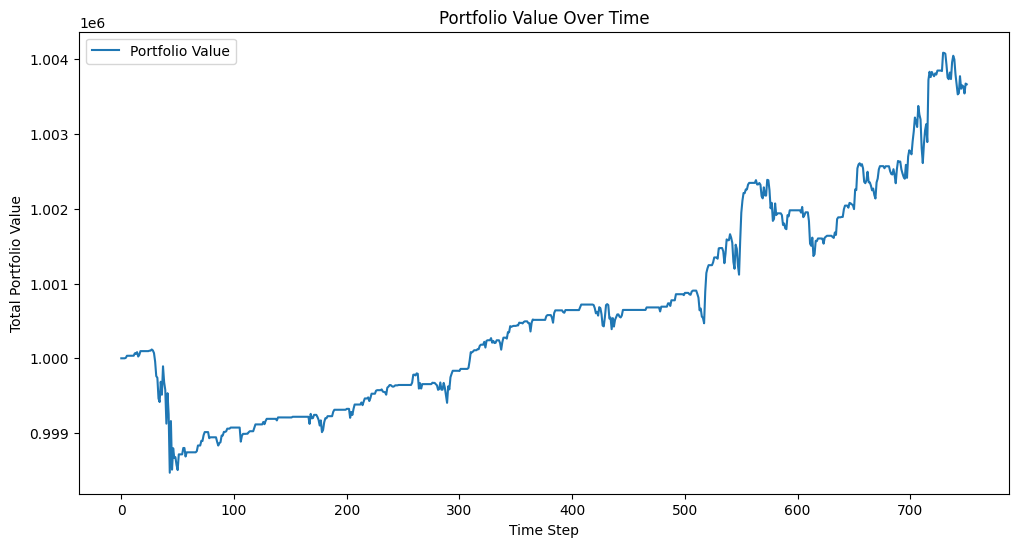

In [91]:
import matplotlib.pyplot as plt

# Initialize portfolio for testing
testPortfolio = TradingPortfolio(initialCash=1000000)

portfolioValues = []
actionsTaken = []

# Test the agent on the price series
for t in range(windowSize, len(prices)):
    # Get current state and discretize
    state = getTrendState(prices, t, windowSize)
    discreteState = discretizeState(state, threshold)

    # Choose the best action according to Q-table
    if discreteState in qTable:
        action = int(np.argmax(qTable[discreteState]))
    else:
        action = 0  # default to Hold if unseen state

    # Take action and update portfolio
    reward = testPortfolio.step(action, prices[t])

    # Track values
    portfolioValues.append(testPortfolio.totalValue)
    actionsTaken.append(action)

# Plot portfolio value over time
plt.figure(figsize=(12,6))
plt.plot(range(len(portfolioValues)), portfolioValues, label="Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Total Portfolio Value")
plt.legend()
plt.show()



In [92]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, inputSize, outputSize, hiddenSize=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize)
        self.fc2 = nn.Linear(hiddenSize, outputSize)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

inputSize = windowSize       # number of features in state
outputSize = 3               # actions: Hold, Buy, Sell
qNetwork = QNetwork(inputSize, outputSize)
optimizer = optim.Adam(qNetwork.parameters(), lr=0.001)
lossFn = nn.MSELoss()  # mean squared error for Q-value update


import numpy as np
import torch

# Hyperparameters
gamma = 0.9          # discount factor
epsilon = 0.3        # exploration rate
numEpisodes = 10

# Actions: Hold=0, Buy=1, Sell=2
actions = [0, 1, 2]

# Loop over episodes
for episode in range(numEpisodes):
    tradingPortfolio = TradingPortfolio(initialCash=1000000)

    for t in range(windowSize, len(prices)):
        # Get current state
        state = getTrendState(prices, t, windowSize)
        stateTensor = torch.FloatTensor(state)
        stateTensor = stateTensor.unsqueeze(0)

        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            with torch.no_grad():
                qValues = qNetwork(stateTensor)
                action = torch.argmax(qValues).item()

        # Take action in portfolio
        reward = tradingPortfolio.step(action, prices[t])

        # Get next state
        if t < len(prices) - 1:
            nextState = getTrendState(prices, t + 1, windowSize)
        else:
            nextState = state
        nextStateTensor = torch.FloatTensor(nextState)

        # Compute target Q-value
        with torch.no_grad():
            maxNextQ = torch.max(qNetwork(nextStateTensor))
            targetQ = reward + gamma * maxNextQ

        # Compute predicted Q-value for the action taken
        predictedQ = qNetwork(stateTensor)[0, action]

        # Compute loss and update network
        loss = lossFn(predictedQ, targetQ)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Episode {episode+1}, Portfolio total value: {tradingPortfolio.totalValue:.2f}")


Episode 1, Portfolio total value: 1007908.11
Episode 2, Portfolio total value: 1002518.49
Episode 3, Portfolio total value: 1002081.92
Episode 4, Portfolio total value: 1003795.04
Episode 5, Portfolio total value: 1000810.12
Episode 6, Portfolio total value: 1006944.31
Episode 7, Portfolio total value: 1005827.47
Episode 8, Portfolio total value: 1004536.27
Episode 9, Portfolio total value: 1006284.27
Episode 10, Portfolio total value: 1003476.18


/tmp/ipython-input-1819180208.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start='2015-01-01', end='2018-01-01')
[*********************100%***********************]  1 of 1 completed

Total Profit: 137.63
Cumulative Reward: 137.63
Sharpe Ratio: 0.40


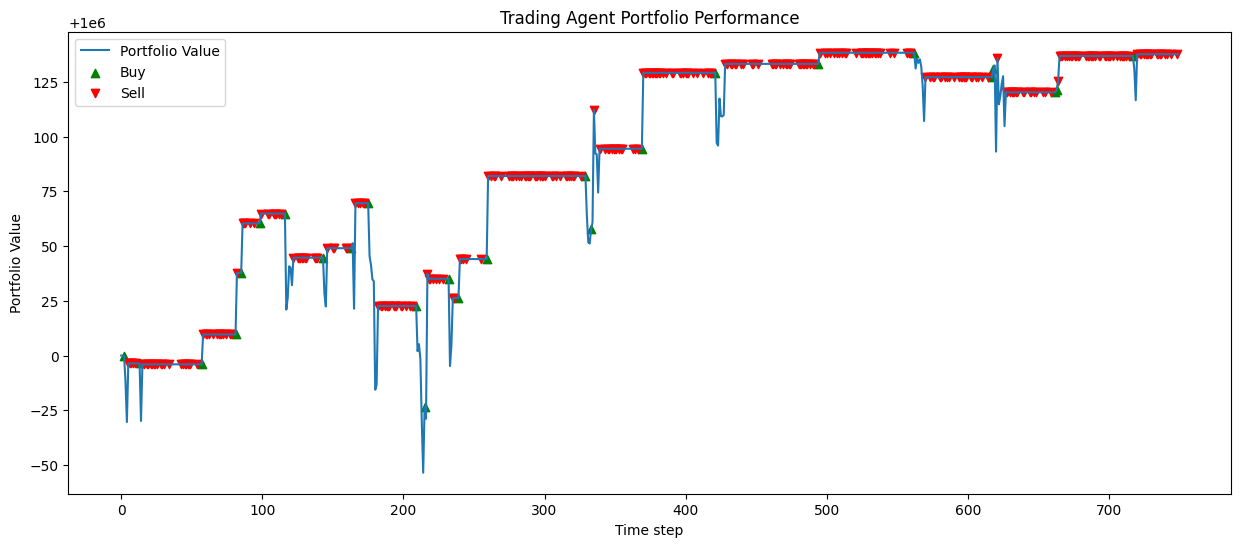

In [93]:
# Testing
data = yf.download(symbol, start='2015-01-01', end='2018-01-01')

prices = data['Close'].to_numpy().flatten()

# Initialize portfolio
evalPortfolio = TradingPortfolio(initialCash=1000000)

# Store metrics
portfolioValues = []
actionsTaken = []

# Loop over historical prices
for t in range(windowSize, len(prices)):
    state = getTrendState(prices, t, windowSize)
    stateTensor = torch.FloatTensor(state).unsqueeze(0)

    # Choose action (greedy, no exploration)
    with torch.no_grad():
        qValues = qNetwork(stateTensor)
        action = torch.argmax(qValues).item()

    # Take action
    reward = evalPortfolio.step(action, prices[t])

    # Record
    portfolioValues.append(evalPortfolio.totalValue)
    actionsTaken.append(action)


totalProfit = evalPortfolio.totalValue - 1000000
print(f"Total Profit: {totalProfit:.2f}")


cumulativeReward = sum(np.diff(portfolioValues))
print(f"Cumulative Reward: {cumulativeReward:.2f}")


dailyReturns = np.diff(portfolioValues) / portfolioValues[:-1]
sharpeRatio = np.mean(dailyReturns) / (np.std(dailyReturns) + 1e-8) * np.sqrt(252)  # annualized
print(f"Sharpe Ratio: {sharpeRatio:.2f}")


plt.figure(figsize=(15,6))

# Plot portfolio value
plt.plot(range(len(portfolioValues)), portfolioValues, label='Portfolio Value')

# Plot buy/sell actions
buyIndices = [i for i, a in enumerate(actionsTaken) if a == 1]
sellIndices = [i for i, a in enumerate(actionsTaken) if a == 2]
plt.scatter(buyIndices, [portfolioValues[i] for i in buyIndices], marker='^', color='g', label='Buy')
plt.scatter(sellIndices, [portfolioValues[i] for i in sellIndices], marker='v', color='r', label='Sell')

plt.xlabel('Time step')
plt.ylabel('Portfolio Value')
plt.title('Trading Agent Portfolio Performance')
plt.legend()
plt.show()
